<a href="https://colab.research.google.com/github/jarammm/YOLOv1/blob/main/realtime_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 상단의 `Open in Colab`을 클릭하여 구글 코랩에서 실행하세요!

# 1 Clone git repository

In [1]:
!git clone https://github.com/jarammm/YOLOv1.git

Cloning into 'YOLOv1'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 123 (delta 53), reused 90 (delta 29), pack-reused 0
Receiving objects: 100% (123/123), 50.96 KiB | 2.21 MiB/s, done.
Resolving deltas: 100% (53/53), done.


# 2 Move directory to git repository

In [4]:
%cd YOLOv1/

/content/YOLOv1


# 3 Import libraries

In [5]:
# import dependencies
from utils import *
from yolo import *
import torch
from torch import nn
import torchvision
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt

# 4 Define functions for real-time object-detection

> 주피터노트북 위에서 실시간 객체탐지를 하기 위해 필요한 함수를 정의합니다.

In [6]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

In [7]:
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [8]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# 5 Download model from git repository

In [9]:
from utils import *
from yolo import *
import torch
from torch import nn, tensor
import torchvision
import cv2
import gdown
from pathlib import Path
from google.colab.output import eval_js


url="https://github.com/jarammm/YOLOv1/releases/download/v0.0.0/yolo_weights.pth"
model_weight_path = 'model/yolo_weights.pth'
dir_to_save = 'model'
Path(dir_to_save).mkdir(parents=True, exist_ok=True)


gdown.download(url, model_weight_path, quiet=False)

Downloading...
From: https://github.com/jarammm/YOLOv1/releases/download/v0.0.0/yolo_weights.pth
To: /content/YOLOv1/model/yolo_weights.pth
100%|██████████| 1.02G/1.02G [00:22<00:00, 44.8MB/s]


'model/yolo_weights.pth'

# 6 Load model

In [11]:
model_weight_path = '/content/YOLOv1/model/yolo_weights.pth'

resnet18 = torchvision.models.resnet18(pretrained=True)
backbone = nn.Sequential(*list(resnet18.children())[:-2]) # remove avg pool and fc
net = yolo.Yolo(backbone, backbone_out_channels=512)

net.load_state_dict(torch.load(model_weight_path))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

<IPython.core.display.Javascript object>

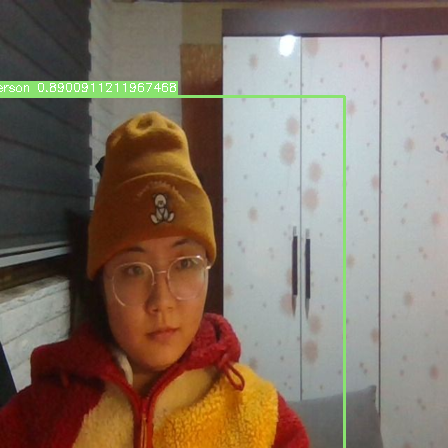

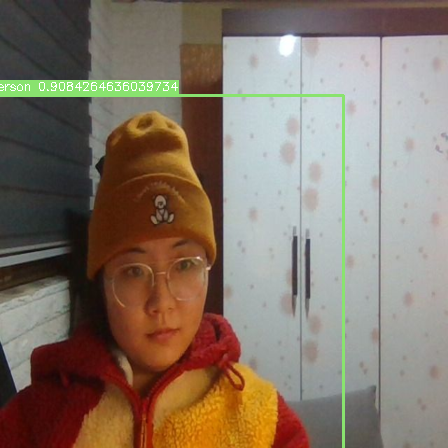

KeyboardInterrupt: ignored

In [18]:
from utils import *
from yolo import *
import torch
from torch import nn, tensor
import torchvision
import cv2
import gdown
from pathlib import Path
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow


net.eval()
net.to('cuda')

video_stream()
label_html = 'Capturing...'
bbox = ''

while True:
	js_reply = video_frame(label_html, bbox)

	if not js_reply:
		break
	
	# convert JS response to OpenCV Image
	frame = js_to_image(js_reply["img"])
 
	img = torchvision.transforms.functional.resize(cv2_to_PIL(frame), (448, 448))
	to_tensor = torchvision.transforms.ToTensor()
	X = to_tensor(img).unsqueeze_(0).to('cuda')
	# X = to_tensor(img).unsqueeze_(0)
	YHat = net(X)
	for x, yhat in zip(X, YHat):
		yhat = nms(yhat)
		cv2_imshow(draw_detection_result(tensor_to_cv2(x), yhat, raw=False, thres=0.1))

	cv2.waitKey(1)